In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rescomp
import scipy

import matplotlib.pyplot as plt
import os

# new imports:
import rescomp.lyapunov_analysis as la

# Datasimulation:

## Lorenz:

In [29]:
# get data (Lorenz):

starting_point = None
# starting_point = np.random.randn(3)*5
time_steps = 100000
dt = 0.01
sys_flag = "lorenz"

sigma = 16.0
rho = 45.92
beta = 4.0

time_series = rescomp.simulations.simulate_trajectory(sys_flag, dt, time_steps, starting_point,
                                                      sigma=sigma, rho=rho, beta=beta) # [10000:, :]

# step = 10
# time_series = time_series[::step]
# dt = step*dt

## Logistic Map:

In [729]:
# get data (Logistic Map):

starting_point = np.array([0.3,])
time_steps = 100000
dt = 1
sys_flag = "logistic"

time_series = rescomp.simulations.simulate_trajectory(sys_flag, dt, time_steps, starting_point)# [1000:, :]

## Roessler:

In [2]:
# roessler:

starting_point = None
time_steps = int(1e5)
dt = 0.01
sys_flag = "roessler_sprott"
a = 0.15
b = 0.20
c = 10.0

time_series = rescomp.simulations.simulate_trajectory(sys_flag, dt, time_steps, starting_point, a=a, b=b,
                                                      c=c)

## Henon:

In [3]:
# henon

starting_point = np.array([0.3, 0.1])
time_steps = 100000
dt = 1
sys_flag = "henon"

time_series = rescomp.simulations.simulate_trajectory(sys_flag, dt, time_steps, starting_point)# [1000:, :]

## Kuramoto-Sivachinsky

In [95]:
# KS
L = 36
dims = 54
fft_type = "scipy"

x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

time_steps = 100000
dt = 0.1
# sys_flag = "kuramoto_sivashinsky"
sys_flag = "kuramoto_sivashinsky_custom"

time_series = rescomp.simulations.simulate_trajectory(sys_flag, dt, time_steps, starting_point, dimensions=dims, system_size=L, fft_type=fft_type)

# Plot time series:

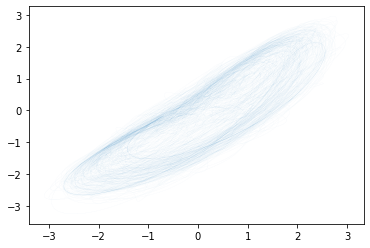

In [96]:
# > 1D
if time_series.shape[1] != 1:
  plt.plot(time_series[:, 0], time_series[:, 1], linewidth=0.01)
  # plt.scatter(time_series[:, 0], time_series[:, 1], s=0.1)
else:
  # 1D
  start = 0
  end = 1000
  plt.scatter(time_series[start:end, 0], time_series[start+1:end+1, 0], s=1)
  # plt.plot(time_series[start:end, 0], time_series[start+1:end+1, 0], linewidth=0.01)


# Fourier Analysis:

1119.786964474813


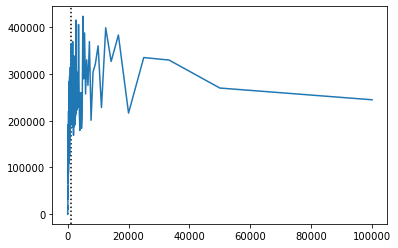

In [97]:
# fourier transform:
fourier = np.fft.fftn(time_series)
mean_fourier = np.linalg.norm(fourier, axis=-1)

freq = np.fft.fftfreq(time_series[:, 0].size)

N = mean_fourier.size
half_fourier = mean_fourier[1:int(N/2)]
half_freq = freq[1:int(N/2)]
half_perdiod = 1/half_freq

avg_period =  np.sum(half_perdiod*half_fourier)/np.sum(half_fourier)
print(avg_period)
#
plt.axvline(avg_period, c = "k", linestyle=":")
plt.plot(half_perdiod, half_fourier)
# plt.xlim(0, 200)

# Rosenstein Algorithm:

## Calculation:

In [98]:
tree = scipy.spatial.cKDTree(time_series)

In [87]:
# simple:
# nr_points = time_series.shape[0]
# neighbour_array = np.zeros((nr_points, ), dtype=int)
#
# for it in range(nr_points):
#     x = time_series[it, :]
#     neighbour = tree.query(x, k=2)[1][1]
#     neighbour_array[it] = neighbour

In [106]:
# with mean frequency:

pnts_to_try = 50

nr_points = time_series.shape[0]
neighbour_array = np.zeros((nr_points, ), dtype=float)
index_distance_array = np.zeros((nr_points, ), dtype=float)
period_cut = avg_period
# period_cut = 0
print("avg_period: ", avg_period)
print("perioid_cut: ", period_cut)
for it in range(nr_points):
    x = time_series[it, :]
    query = tree.query(x, k=pnts_to_try)
    potential_neighbours = query[1][1:]
    index_distance = np.abs(potential_neighbours-it)
    larger_than_period_cut = index_distance > period_cut
    neighs_larger_than_period_cut = potential_neighbours[larger_than_period_cut]
    if len(neighs_larger_than_period_cut) > 0:
        index_distance_array[it] = index_distance[larger_than_period_cut][0]
        neighbour = neighs_larger_than_period_cut[0]
        neighbour_array[it] = neighbour
    else:
        index_distance_array[it] = np.NaN
        neighbour_array[it] = np.NaN

nans = np.isnan(neighbour_array)
print(f"For {nans.sum()}/{nans.size} points, all {pnts_to_try} closest neighbours were temporally closer than {period_cut} and thus not considered")

avg_period:  1119.786964474813
perioid_cut:  1119.786964474813
For 24532/100000 points, all 50 closest neighbours were temporally closer than 1119.786964474813 and thus not considered


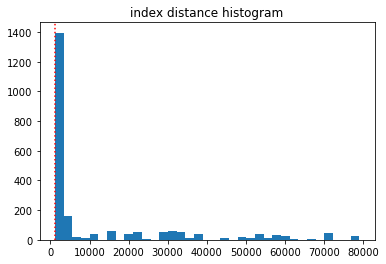

In [100]:
plt.title("index distance histogram")
plt.hist(index_distance_array[~np.isnan(index_distance_array)], bins="auto")
plt.axvline(period_cut, linestyle=":", c="r")

In [101]:
steps = 1000
distance_array = np.empty((nr_points, steps))
distance_array[:, :] = np.NaN

nans_pre = nans.sum()

for i_base, i_neigh in enumerate(neighbour_array):
    if np.isnan(i_neigh):
        continue
    else:
        i_neigh = int(i_neigh)
        if i_base + steps < nr_points and i_neigh + steps < nr_points:
            diff = time_series[i_base:i_base+steps, :] - time_series[i_neigh:i_neigh+steps, :]
            distance_array[i_base, :] = np.linalg.norm(diff, axis=-1)

nans_2 = np.isnan(distance_array).any(axis=1)
print(f"For {nans_2.sum()-nans_pre}/{nans_2.size - nans_pre} points, there were not {steps} steps left in the timeseries (either for the base and/or nn-point)")

For 0/2236 points, there were not 1000 steps left in the timeseries (either for the base and/or nn-point)


In [102]:
# remove rows with nan
d = distance_array[~np.isnan(distance_array).any(axis=1)]
# remove 0 distance:
d_no_zero = d[(d!=0).any(axis=1)]

final_nr_of_pnts = d_no_zero.shape[0]
print(f"final number of points: {final_nr_of_pnts}")
log_d = np.log(d_no_zero)

final number of points: 2236


(array([1102.,  173.,   19.,   53.,   54.,   45.,  125.,  216.,  205.,
         119.,   77.,   35.,   13.]),
 array([0.04301765, 0.29298737, 0.54295709, 0.79292681, 1.04289653,
        1.29286625, 1.54283597, 1.79280569, 2.04277541, 2.29274513,
        2.54271485, 2.79268457, 3.04265429, 3.29262401]),
 <a list of 13 Patch objects>)

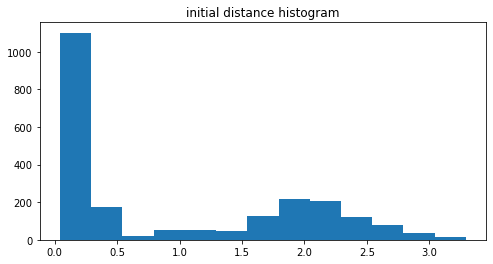

In [103]:
plt.figure(figsize=(8, 4))
plt.title("initial distance histogram")
plt.hist(d[:, 0], bins="auto")

In [104]:
avg_log_dist = np.mean(log_d, axis=0)

## Plot:

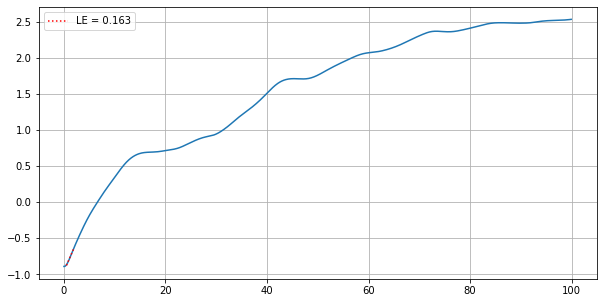

In [105]:
t_list = np.arange(steps)*dt

plt.figure(figsize=(10, 5))

plt.grid()
plt.plot(t_list, avg_log_dist)
# plt.scatter(x=t_list, y=avg_log_dist, s=100, marker="x", alpha=0.5)

# linear fit:
out_fit = la.linear_fit(avg_log_dist, dt=dt, t_min=0.5, t_max=2)
lyap = out_fit[2][0].round(3)
plt.plot(out_fit[0], out_fit[1], label=f"LE = {lyap}", c="r", linestyle=":")

plt.legend()
# plt.xlim(-1, 5)
# plt.ylim(-1.63, -1.60)

# Everything as one function:

In [30]:
out = rescomp.measures.lyapunov_rosenstein(time_series, dt, freq_cut=True, pnts_to_try=50, steps=100, verb=1, debug=True)

avg period: 3.1039759006436722
For 0/100000 points, all 50 closest neighbours were temporally closer than 3.1039759006436722 and thus not considered
For 156/100000 points, there were not 100 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 99844


No handles with labels found to put in legend.


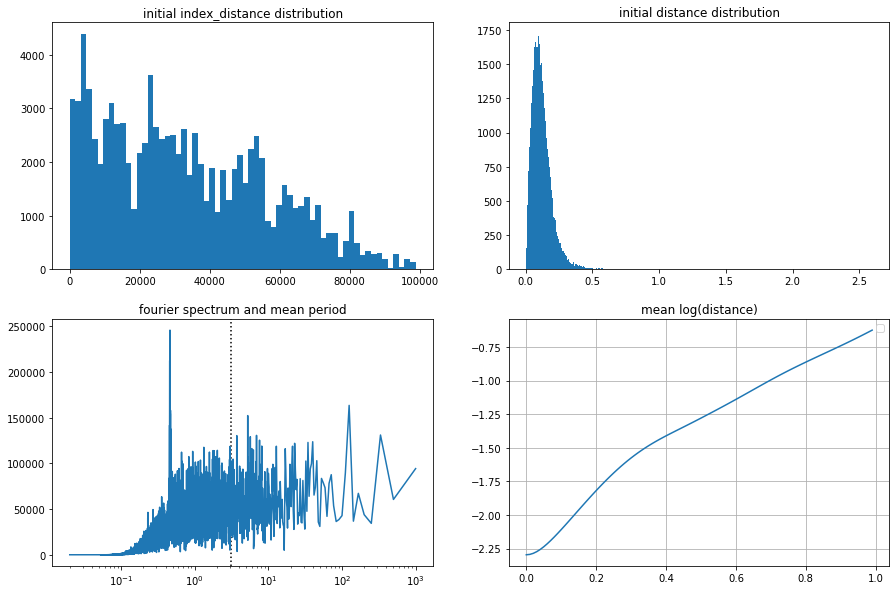

In [37]:
avg_log_dist, t_list, index_distance_array, distance_array, time, amplitude, avg_period = out

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
ax = axs[0, 0]
ax.hist(index_distance_array, bins="auto")
ax.set_title("initial index_distance distribution")

ax = axs[0, 1]
ax.hist(distance_array[:, 0], bins=1000)
ax.set_title("initial distance distribution")
# ax.set_xlim(0, 0.01)

ax = axs[1, 0]
ax.set_xscale('log')
ax.axvline(avg_period, c = "k", linestyle=":")
ax.plot(time, amplitude)
ax.set_title("fourier spectrum and mean period")
# ax.set_xlim(-1000, 20000)

ax = axs[1, 1]
ax.grid()
ax.plot(t_list, avg_log_dist)

# linear fit:
# out_fit = la.linear_fit(avg_log_dist, dt=dt, t_min=0.5, t_max=20)
# lyap = out_fit[2][0].round(3)
# ax.plot(out_fit[0], out_fit[1], label=f"LE = {lyap}", c="r", linestyle=":")

ax.set_title("mean log(distance)")
# ax.set_xlim(-1000, 20000)
ax.legend()

------------------------------------
# Alternative algorithm:
https://github.com/CSchoel/nolds/blob/main/nolds/measures.py

In [ ]:
import warnings

def lyap_r(data, emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0):
  """
  Estimates the largest Lyapunov exponent using the algorithm of Rosenstein
  et al. [lr_1]_.
  Explanation of Lyapunov exponents:
    See lyap_e.
  Explanation of the algorithm:
    The algorithm of Rosenstein et al. is only able to recover the largest
    Lyapunov exponent, but behaves rather robust to parameter choices.
    The idea for the algorithm relates closely to the definition of Lyapunov
    exponents. First, the dynamics of the data are reconstructed using a delay
    embedding method with a lag, such that each value x_i of the data is mapped
    to the vector
    X_i = [x_i, x_(i+lag), x_(i+2*lag), ..., x_(i+(emb_dim-1) * lag)]
    For each such vector X_i, we find the closest neighbor X_j using the
    euclidean distance. We know that as we follow the trajectories from X_i and
    X_j in time in a chaotic system the distances between X_(i+k) and X_(j+k)
    denoted as d_i(k) will increase according to a power law
    d_i(k) = c * e^(lambda * k) where lambda is a good approximation of the
    highest Lyapunov exponent, because the exponential expansion along the axis
    associated with this exponent will quickly dominate the expansion or
    contraction along other axes.
    To calculate lambda, we look at the logarithm of the distance trajectory,
    because log(d_i(k)) = log(c) + lambda * k. This gives a set of lines
    (one for each index i) whose slope is an approximation of lambda. We
    therefore extract the mean log trajectory d'(k) by taking the mean of
    log(d_i(k)) over all orbit vectors X_i. We then fit a straight line to
    the plot of d'(k) versus k. The slope of the line gives the desired
    parameter lambda.
  Method for choosing min_tsep:
    Usually we want to find neighbors between points that are close in phase
    space but not too close in time, because we want to avoid spurious
    correlations between the obtained trajectories that originate from temporal
    dependencies rather than the dynamic properties of the system. Therefore it
    is critical to find a good value for min_tsep. One rather plausible
    estimate for this value is to set min_tsep to the mean period of the
    signal, which can be obtained by calculating the mean frequency using the
    fast fourier transform. This procedure is used by default if the user sets
    min_tsep = None.
  Method for choosing lag:
    Another parameter that can be hard to choose by instinct alone is the lag
    between individual values in a vector of the embedded orbit. Here,
    Rosenstein et al. suggest to set the lag to the distance where the
    autocorrelation function drops below 1 - 1/e times its original (maximal)
    value. This procedure is used by default if the user sets lag = None.
  References:
    .. [lr_1] M. T. Rosenstein, J. J. Collins, and C. J. De Luca,
       “A practical method for calculating largest Lyapunov exponents from
       small data sets,” Physica D: Nonlinear Phenomena, vol. 65, no. 1,
       pp. 117–134, 1993.
  Reference Code:
    .. [lr_a] mirwais, "Largest Lyapunov Exponent with Rosenstein's Algorithm",
       url: http://www.mathworks.com/matlabcentral/fileexchange/38424-largest-lyapunov-exponent-with-rosenstein-s-algorithm
    .. [lr_b] Shapour Mohammadi, "LYAPROSEN: MATLAB function to calculate
       Lyapunov exponent",
       url: https://ideas.repec.org/c/boc/bocode/t741502.html
  Args:
    data (iterable of float):
      (one-dimensional) time series
  Kwargs:
    emb_dim (int):
      embedding dimension for delay embedding
    lag (float):
      lag for delay embedding
    min_tsep (float):
      minimal temporal separation between two "neighbors" (default:
      find a suitable value by calculating the mean period of the data)
    tau (float):
      step size between data points in the time series in seconds
      (normalization scaling factor for exponents)
    min_neighbors (int):
      if lag=None, the search for a suitable lag will be stopped when the
      number of potential neighbors for a vector drops below min_neighbors
    trajectory_len (int):
      the time (in number of data points) to follow the distance
      trajectories between two neighboring points
    fit (str):
      the fitting method to use for the line fit, either 'poly' for normal
      least squares polynomial fitting or 'RANSAC' for RANSAC-fitting which
      is more robust to outliers
    debug_plot (boolean):
      if True, a simple plot of the final line-fitting step will
      be shown
    debug_data (boolean):
      if True, debugging data will be returned alongside the result
    plot_file (str):
      if debug_plot is True and plot_file is not None, the plot will be saved
      under the given file name instead of directly showing it through
      ``plt.show()``
    fit_offset (int):
      neglect the first fit_offset steps when fitting
  Returns:
    float:
      an estimate of the largest Lyapunov exponent (a positive exponent is
      a strong indicator for chaos)
    (1d-vector, 1d-vector, list):
      only present if debug_data is True: debug data of the form
      ``(ks, div_traj, poly)`` where ``ks`` are the x-values of the line fit,
      ``div_traj`` are the y-values and ``poly`` are the line coefficients
      (``[slope, intercept]``).
  """
  # convert data to float to avoid overflow errors in rowwise_euclidean
  data = np.asarray(data, dtype="float32")
  n = len(data)
  max_tsep_factor = 0.25
  if lag is None or min_tsep is None:
    # both the algorithm for lag and min_tsep need the fft
    f = np.fft.rfft(data, n * 2 - 1)
  if min_tsep is None:
    # calculate min_tsep as mean period (= 1 / mean frequency)
    # to get the mean frequency, we weight the frequency buckets in the
    # fft result by the absolute power in that bucket and then divide
    # by the total power accross all buckets to get a weigthed mean
    mf = np.fft.rfftfreq(n * 2 - 1) * f**2
    mf = np.sum(mf[1:]) / np.sum(f[1:]**2)
    min_tsep = int(np.ceil(1.0 / mf))
    if min_tsep > max_tsep_factor * n:
      min_tsep = int(max_tsep_factor * n)
      msg = "signal has very low mean frequency, setting min_tsep = {:d}"
      warnings.warn(msg.format(min_tsep), RuntimeWarning)
  if lag is None:
    # calculate the lag as point where the autocorrelation drops to (1 - 1/e)
    # times its maximum value
    # note: the Wiener–Khinchin theorem states that the spectral
    # decomposition of the autocorrelation function of a process is the power
    # spectrum of that process
    # => we can use fft to calculate the autocorrelation
    acorr = np.fft.irfft(f * np.conj(f))
    acorr = np.roll(acorr, n - 1)
    eps = acorr[n - 1] * (1 - 1.0 / np.e)
    lag = 1
    # small helper function to calculate resulting number of vectors for a
    # given lag value
    def nb_neighbors(lag_value):
      min_len = lyap_r_len(
        emb_dim=emb_dim, lag=i, trajectory_len=trajectory_len,
        min_tsep=min_tsep
      )
      return max(0, n - min_len)
    # find lag
    for i in range(1,n):
      lag = i
      if acorr[n - 1 + i] < eps or acorr[n - 1 - i] < eps:
        break
      if nb_neighbors(i) < min_neighbors:
        msg = "autocorrelation declined too slowly to find suitable lag" \
          + ", setting lag to {}"
        warnings.warn(msg.format(lag), RuntimeWarning)
        break
  min_len = lyap_r_len(
    emb_dim=emb_dim, lag=lag, trajectory_len=trajectory_len,
    min_tsep=min_tsep
  )
  if len(data) < min_len:
    msg = "for emb_dim = {}, lag = {}, min_tsep = {} and trajectory_len = {}" \
      + " you need at least {} datapoints in your time series"
    warnings.warn(
      msg.format(emb_dim, lag, min_tsep, trajectory_len, min_len),
      RuntimeWarning
    )
  # delay embedding
  orbit = delay_embedding(data, emb_dim, lag)
  m = len(orbit)
  # construct matrix with pairwise distances between vectors in orbit
  dists = np.array([rowwise_euclidean(orbit, orbit[i]) for i in range(m)])
  # we do not want to consider vectors as neighbor that are less than min_tsep
  # time steps together => mask the distances min_tsep to the right and left of
  # each index by setting them to infinity (will never be considered as nearest
  # neighbors)
  for i in range(m):
    dists[i, max(0, i - min_tsep):i + min_tsep + 1] = float("inf")
  # check that we have enough data points to continue
  ntraj = m - trajectory_len + 1
  min_traj = min_tsep * 2 + 2 # in each row min_tsep + 1 disances are inf
  if ntraj <= 0:
    msg = "Not enough data points. Need {} additional data points to follow " \
        + "a complete trajectory."
    raise ValueError(msg.format(-ntraj+1))
  if ntraj < min_traj:
    # not enough data points => there are rows where all values are inf
    assert np.any(np.all(np.isinf(dists[:ntraj, :ntraj]), axis=1))
    msg = "Not enough data points. At least {} trajectories are required " \
        + "to find a valid neighbor for each orbit vector with min_tsep={} " \
        + "but only {} could be created."
    raise ValueError(msg.format(min_traj, min_tsep, ntraj))
  assert np.all(np.any(np.isfinite(dists[:ntraj, :ntraj]), axis=1))
  # find nearest neighbors (exclude last columns, because these vectors cannot
  # be followed in time for trajectory_len steps)
  nb_idx = np.argmin(dists[:ntraj, :ntraj], axis=1)

  # build divergence trajectory by averaging distances along the trajectory
  # over all neighbor pairs
  div_traj = np.zeros(trajectory_len, dtype=float)
  for k in range(trajectory_len):
    # calculate mean trajectory distance at step k
    indices = (np.arange(ntraj) + k, nb_idx + k)
    div_traj_k = dists[indices]
    # filter entries where distance is zero (would lead to -inf after log)
    nonzero = np.where(div_traj_k != 0)
    if len(nonzero[0]) == 0:
      # if all entries where zero, we have to use -inf
      div_traj[k] = -np.inf
    else:
      div_traj[k] = np.mean(np.log(div_traj_k[nonzero]))
  # filter -inf entries from mean trajectory
  ks = np.arange(trajectory_len)
  finite = np.where(np.isfinite(div_traj))
  ks = ks[finite]
  div_traj = div_traj[finite]
  return div_traj
  # if len(ks) < 1:
  #   # if all points or all but one point in the trajectory is -inf, we cannot
  #   # fit a line through the remaining points => return -inf as exponent
  #   poly = [-np.inf, 0]
  # else:
  #   # normal line fitting
  #   poly = poly_fit(ks[fit_offset:], div_traj[fit_offset:], 1, fit=fit)
  # if debug_plot:
  #   plot_reg(ks[fit_offset:], div_traj[fit_offset:], poly, "k", "log(d(k))", fname=plot_file)
  # le = poly[0] / tau
  # if debug_data:
  #   return (le, (ks, div_traj, poly))
  # else:
  #   return le

def lyap_r_len(**kwargs):
  """
  Helper function that calculates the minimum number of data points required
  to use lyap_r.
  Note that none of the required parameters may be set to None.
  Kwargs:
    kwargs(dict):
      arguments used for lyap_r (required: emb_dim, lag, trajectory_len and
      min_tsep)
  Returns:
    minimum number of data points required to call lyap_r with the given
    parameters
  """
  # minimum length required to find single orbit vector
  min_len = (kwargs['emb_dim'] - 1) * kwargs['lag'] + 1
  # we need trajectory_len orbit vectors to follow a complete trajectory
  min_len += kwargs['trajectory_len'] - 1
  # we need min_tsep * 2 + 1 orbit vectors to find neighbors for each
  min_len += kwargs['min_tsep'] * 2 + 1
  return min_len


def delay_embedding(data, emb_dim, lag=1):
  """
  Perform a time-delay embedding of a time series
  Args:
    data (array-like):
      the data that should be embedded
    emb_dim (int):
      the embedding dimension
  Kwargs:
    lag (int):
      the lag between elements in the embedded vectors
  Returns:
    emb_dim x m array:
      matrix of embedded vectors of the form
      [data[i], data[i+lag], data[i+2*lag], ... data[i+(emb_dim-1)*lag]]
      for i in 0 to m-1 (m = len(data)-(emb_dim-1)*lag)
  """
  data = np.asarray(data)
  min_len = (emb_dim - 1) * lag + 1
  if len(data) < min_len:
    msg = "cannot embed data of length {} with embedding dimension {} " \
        + "and lag {}, minimum required length is {}"
    raise ValueError(msg.format(len(data), emb_dim, lag, min_len))
  m = len(data) - min_len + 1
  indices = np.repeat([np.arange(emb_dim) * lag], m, axis=0)
  indices += np.arange(m).reshape((m, 1))
  return data[indices]

def rowwise_euclidean(x, y):
  return np.sqrt(np.sum((x - y)**2, axis=1))

def poly_fit(x, y, degree, fit="RANSAC"):
  # check if we can use RANSAC
  if fit == "RANSAC":
    try:
      # ignore ImportWarnings in sklearn
      with warnings.catch_warnings():
        warnings.simplefilter("ignore", ImportWarning)
        import sklearn.linear_model as sklin
        import sklearn.preprocessing as skpre
    except ImportError:
      warnings.warn(
        "fitting mode 'RANSAC' requires the package sklearn, using"
        + " 'poly' instead",
        RuntimeWarning)
      fit = "poly"

  if fit == "poly":
    return np.polyfit(x, y, degree)
  elif fit == "RANSAC":
    model = sklin.RANSACRegressor(sklin.LinearRegression(fit_intercept=False))
    xdat = np.asarray(x)
    if len(xdat.shape) == 1:
      # interpret 1d-array as list of len(x) samples instead of
      # one sample of length len(x)
      xdat = xdat.reshape(-1, 1)
    polydat = skpre.PolynomialFeatures(degree).fit_transform(xdat)
    try:
      model.fit(polydat, y)
      coef = model.estimator_.coef_[::-1]
    except ValueError:
      warnings.warn(
        "RANSAC did not reach consensus, "
        + "using numpy's polyfit",
        RuntimeWarning)
      coef = np.polyfit(x, y, degree)
    return coef
  else:
    raise ValueError("invalid fitting mode ({})".format(fit))

In [ ]:
lyap_r(time_series[:, 0:1], emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0)

# OLD:

In [ ]:
# fourier transform:
fourier = np.fft.fftn(time_series)
mean_fourier = np.linalg.norm(fourier, axis=-1)
# freq = np.fft.fftfreq(time_series[:, 0].size, d=dt)
# mean_fourier = fourier[:, 2]
N = mean_fourier.size
half_fourier = mean_fourier[:int(N/2)]
ind_freq = np.arange(half_fourier.size)
avg_frequency =  np.sum(ind_freq*half_fourier)/np.sum(half_fourier)
print(avg_frequency)

plt.axvline(avg_frequency, c = "k", linestyle=":")
plt.plot(half_fourier)

# plt.plot(freq, mean_fourier)
# plt.ylim(0, 100000)
# plt.xlim(0, 10)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack

# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [ ]:
# fourier transform:
fourier = np.fft.fftn(time_series)
# mean_fourier = np.mean(fourier, axis=-1)
mean_fourier = np.linalg.norm(fourier, axis=-1)
freq = np.fft.fftfreq(time_series[:, 0].size, d=dt)
# mean_fourier = fourier[:, 2]

print(np.sum(freq*mean_fourier)/np.sum(mean_fourier))

plt.plot(freq, mean_fourier)
plt.ylim(0, 100000)
plt.xlim(0, 10)

In [ ]:
t = np.arange(0, 1, 0.001)
signal = np.sin(2*np.pi*t*10) + np.sin(2*np.pi*t*5)
plt.plot(signal)

# mean period is 1/10 = 0.1 = T
# mean perioid in points is T/dt = 100

In [ ]:
# fourier transform:
# fourier = np.fft.fftshift(np.fft.fft(signal))
fourier = np.fft.fft(signal)

# freq = np.fft.fftfreq(signal.size, d=0.001)
freq = np.fft.fftfreq(signal.size, d=1)

freq_half = freq[:int(freq.size/2)]
fourier_half = fourier[:int(fourier.size/2)]
plt.plot(1/freq_half, np.abs(fourier_half)**2)

# plt.plot(np.linspace(0, 1, len(t), endpoint=True), np.abs(fourier)**2)
# plt.plot(1/freq, np.abs(fourier)**2)
# plt.xlim(-0.25, 0.25)
